<a href="https://colab.research.google.com/github/APWright/6242Project/blob/master/Analysis/6242.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
import os
import networkx

In [0]:
!pip install pygam
import pygam

     |████████████████████████████████| 1.8MB 2.7MB/s 


In [0]:
from getpass import getpass
username = input('Github Username: ')
password = getpass('Github Password: ')
clone_repo = "git clone https://{}:{}@github.com/APWright/6242Project.git".format(username,password)
os.system(clone_repo)
password = ""
%cd 6242Project/Analysis

Github Username: apwright
Github Password: ··········
/content/6242Project/Analysis


In [0]:
codes = pd.read_csv("../Data/RawData/iso_codes_numeric_abbrevs.csv")
data_index = ['src_num', 'src_abb', 'tgt_num', 'tgt_abb', 'year']

democracy_score = pd.read_csv("../Data/CleanData/Democracy-Autocracy-score-csv.csv")
gdp_score = pd.read_csv("../Data/CleanData/GDP_per_cap_clean_rev2.csv").rename(columns={'origin_abb':'src_abb','origin_num':'src_num','dest_num':'tgt_num','dest_abb':'tgt_abb'})
avg_temp = pd.read_csv("../Data/CleanData/average_temp_country.csv").rename(columns={'origin_abb':'src_abb','origin_numeric':'src_num','destination_numeric':'tgt_num','destination_abb':'tgt_abb'})
avg_school_years = pd.read_csv("../Data/CleanData/avg_school_years_imputeclosest.csv")
birth_rates = pd.read_csv("../Data/CleanData/birth_rates.csv")
land_locked = pd.read_csv("../Data/CleanData/country_land_locked_clean.csv")
water_scaricity = pd.read_csv("../Data/CleanData/country_water_scarcity_clean.csv")
natural_disasters = pd.read_csv("../Data/CleanData/natural_disaster_clean.csv")

population = pd.read_csv("../Data/CleanData/population-csv.csv").rename(columns={'Country Code':'src_abb','Numeric code':'src_num'}).drop(["Country Name",'src_abb'],axis=1).melt(id_vars=['src_num'],var_name='year',value_name='population').dropna()
population['year'] = population['year'].astype(int)
population['population'] = population['population'].astype(int)

node_features = pd.merge(democracy_score,gdp_score, on=data_index,how='outer')
node_features = pd.merge(node_features,avg_temp, on=data_index,how='outer').drop(['Unnamed: 0',"Name"],axis=1).rename(columns={'avg':'avg_temp'})
node_features = pd.merge(node_features,avg_school_years, on=data_index,how='outer')
node_features = pd.merge(node_features,birth_rates, on=data_index,how='outer')
node_features = pd.merge(node_features,land_locked, on=data_index,how='outer').drop(['Unnamed: 0',"Country"],axis=1)
water_scaricity['Risk_Level'] = water_scaricity['Risk_Level'].map(lambda rl: {'Extremely-high':5, 'High':4, 'Low':1, 'Low-medium':2, 'Medium-high':3}[rl])
node_features = pd.merge(node_features,water_scaricity, on=data_index,how='outer').drop(['Unnamed: 0','Rank ',"Country",'Extremely-high', 'High', 'Low', 'Low-medium', 'Medium-high'],axis=1).rename(columns={'Risk_Level':'water_risk'})
node_features = pd.merge(node_features,natural_disasters, on=data_index,how='outer').drop(['Unnamed: 0',"Country","Prone_Disasters"],axis=1)
node_features = node_features.drop(['src_abb', 'tgt_num', 'tgt_abb'],axis=1)
node_features = population.merge(node_features,on=['src_num','year'],how='outer')
node_features = node_features.fillna(0)

In [0]:
trade = pd.read_csv("../Data/CleanData/trade_depencies_rev2.zip").rename(columns={'origin_abb':'src_abb','origin_num':'src_num','dest_num':'tgt_num','dest_abb':'tgt_abb'}).dropna()
trade['year'] = trade['year'].astype(int)
conflict = pd.read_csv("../Data/CleanData/ucdp_conflict_rev2.zip").rename(columns={'year0':'year','orig':'src_abb','orig_code':'src_num','dest_code':'tgt_num','dest':'tgt_abb','intensity_level':'conflict'})
contiguous_states = pd.read_csv("../Data/CleanData/contiguous_states_rev2.zip").rename(columns={'year0':'year','orig':'src_abb','orig_code':'src_num','dest_code':'tgt_num','dest':'tgt_abb'})
edge_features = conflict.merge(trade,on=data_index,how='outer').merge(contiguous_states,on=data_index,how='outer')

edge_inv = edge_features.rename(columns={'src_abb':'tgt_abb','src_num':'tgt_num','tgt_abb':'src_abb','tgt_num':'src_num'})
edge_features = pd.merge(edge_features,edge_inv,on=data_index,how='outer',suffixes=('','_inv'))
edge_features.fillna(0)

migration = pd.read_csv("../Data/CleanData/migration_flows_all_years.csv",index_col=0).rename(columns={'year0':'year',
                                                                                                       'orig': 'src_abb',
                                                                                                       'dest':'tgt_abb',
                                                                                                       'orig_code':'src_num',
                                                                                                       'dest_code':'tgt_num'})
migration['year'] = migration['year'].map(lambda t: int(t[:4]))

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
def print_stats(feat):
  print("\n\n")
  print(feat)
  if len(np.unique(node_features[feat])) < 20:
    print(np.unique(node_features[feat]))
  print(np.mean(node_features[feat]),np.std(node_features[feat]))
[print_stats(feat) for feat in node_features.columns[2:]]




population
11356500.567189708 70714482.87350978



democ
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
2.143972633301108 3.4970827751834834



autoc
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
2.144270097419499 3.2035401423763163



GDP_per_cap
2538.1102964397514 8168.556048586548



avg_temp
16.24203779190504 10.066144182002217



years_in_school
2.541903175429483 3.5572416640224365



birth_rateper1000
11.861670389851096 16.582010476291803



LandLocked
[0. 1.]
0.16598497806202128 0.3720671513581547



water_risk
[0. 1. 2. 3. 4. 5.]
1.6178329738975237 1.6475776335774612



snow
[0. 1.]
0.008923923551721573 0.09404407020202592



tsunami
[0. 1.]
0.05800550308619023 0.23375385493701056



tornado
[0. 1.]
0.008923923551721573 0.09404407020202593



avalanche
[0. 1.]
0.031233732431025507 0.17394880393219422



fire
[0. 1.]
0.17401650925857068 0.37912367871708436



severe_storms
[0. 1.]
0.2641481371309586 0.440878553324259



mudslide
[0. 1.]
0.017847847103443146 0.13239826833161938

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [0]:
(min(np.unique(migration['year'])),max(np.unique(migration['year']))) 

(1960, 2014)

In [0]:
start_year = 1960
end_year = 2015

In [0]:
node_features = node_features[node_features['year'] >= start_year]
node_features = node_features[node_features['year'] <= end_year]
edge_features = edge_features[edge_features['year'] >= start_year]
edge_features = edge_features[edge_features['year'] <= end_year]

In [0]:
regression_df = pd.merge(edge_features,node_features,on=['src_num','year'],how='outer')
regression_df = pd.merge(regression_df,node_features,left_on=['tgt_num','year'],right_on=['src_num','year'],suffixes=('_src','_tgt'),how='outer')
regression_df = regression_df.drop(['src_num_tgt'],axis=1)
regression_df = regression_df.rename(columns={'src_num_src':'src_num'})
regression_df = regression_df.fillna(0)
regression_df

,year,src_abb,tgt_abb,src_num,tgt_num,conflict,trade_dependence,conttype,conflict_inv,trade_dependence_inv,conttype_inv,population_src,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,population_tgt,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,1960,ABW,ABW,533.0,533.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.00,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1960,AFG,ABW,4.0,533.0,0.0,0.000000e+00,0.0,0.0,2.633481e-04,0.0,8996973.0,0.0,10.0,59.773194,14.091667,0.22,51.279,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1960,AGO,ABW,24.0,533.0,0.0,6.703448e-08,0.0,0.0,0.000000e+00,0.0,5454933.0,0.0,0.0,710.981648,21.930441,4.40,49.080,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1960,ALB,ABW,8.0,533.0,0.0,1.222307e-05,0.0,0.0,1.103166e-07,0.0,1608800.0,0.0,9.0,639.484736,15.337917,2.32,40.924,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1960,ARE,ABW,784.0,533.0,0.0,6.476933e-06,0.0,0.0,8.306788e-05,0.0,92418.0,0.0,0.0,26847.794380,26.829167,1.38,47.266,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120849,2015,0,0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2120850,2015,0,0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,27.149500,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2120851,2015,0,0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,25.812083,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2120852,2015,0,0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,27.255000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
total_regression_df = pd.merge(migration,regression_df,on=data_index)
total_regression_df = total_regression_df.fillna(0.0)
total_regression_df

,year,src_abb,tgt_abb,src_num,tgt_num,flow,conflict,trade_dependence,conttype,conflict_inv,trade_dependence_inv,conttype_inv,population_src,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,population_tgt,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,1960,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1961,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55438.0,0.0,0.0,6472.502029,0.000000,0.0,34.529,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,55438.0,0.0,0.0,6472.502029,0.000000,0.0,34.529,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1962,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56225.0,0.0,0.0,6472.502029,0.000000,0.0,33.320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56225.0,0.0,0.0,6472.502029,0.000000,0.0,33.320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1963,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56695.0,0.0,0.0,6472.502029,0.000000,0.0,32.050,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56695.0,0.0,0.0,6472.502029,0.000000,0.0,32.050,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1964,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57032.0,0.0,0.0,6472.502029,0.000000,0.0,30.737,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,57032.0,0.0,0.0,6472.502029,0.000000,0.0,30.737,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088697,2010,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12697723.0,3.0,2.0,948.331854,20.564583,7.3,36.464,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12697723.0,3.0,2.0,948.331854,20.564583,7.3,36.464,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2088698,2011,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12894316.0,3.0,2.0,1093.654002,20.305833,7.3,36.526,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12894316.0,3.0,2.0,1093.654002,20.305833,7.3,36.526,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2088699,2012,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13115131.0,3.0,2.0,1304.969802,19.982500,7.9,36.292,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13115131.0,3.0,2.0,1304.969802,19.982500,7.9,36.292,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2088700,2013,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13350356.0,5.0,1.0,1430.000818,19.682292,8.0,35.768,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13350356.0,5.0,1.0,1430.000818,19.682292,8.0,35.768,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
from pygam import InvGaussGAM, GAM, LinearGAM, s, f
gam = LinearGAM()

In [0]:
y = np.log(total_regression_df['flow']+1.0)
X = total_regression_df[total_regression_df.columns[6:]].values
train_index = (np.random.rand(len(y)) <= 0.5) & (y > 0.1)
test_index  = ~train_index & (y > 0.1)

In [0]:
gam = gam.fit(X[train_index],y[train_index])
baseline = linear_model.LinearRegression(normalize=True).fit(X[train_index],y[train_index])

In [0]:
from google.colab import files
import pickle

save_model=  open("gam.pkl",mode='wb')
pickle.dump(gam,save_model)
files.download('gam.pkl')

In [0]:
load_model =  open("gam.pkl",mode='rb')

gam = pickle.load(load_model)

In [0]:
scipy.stats.pearsonr(gam.predict(X[train_index]),y[train_index])

(0.6079533557164113, 0.0)

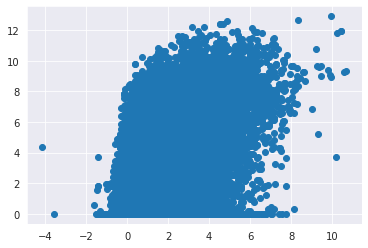

In [0]:
plt.scatter(gam.predict(X[train_index]),y[train_index])

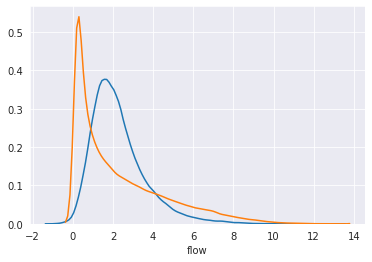

In [0]:
sns.distplot(gam.predict(X[train_index]) ,hist=False)
sns.distplot(y[train_index],hist=False)

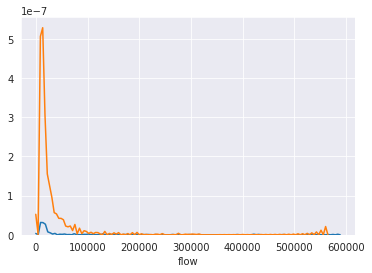

In [0]:
sns.distplot(np.exp(gam.predict(X[train_index])) ,hist=False)
sns.distplot(np.exp(y[train_index]),hist=False)
# plt.ylim(0,0.00000041)
# plt.xlim(100,50000)

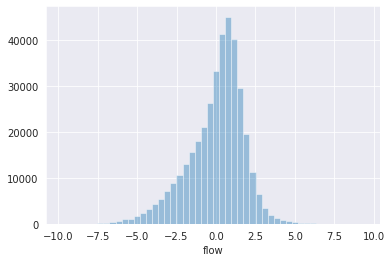

In [0]:
sns.distplot(gam.predict(X[train_index]) - y[train_index],kde=False)

In [0]:
pred, y_test = gam.predict(X[test_index]), y[test_index]

In [0]:
np.std(y_test), np.std(pred - y_test)

(2.2459201578216494, 1.782221983854281)

In [0]:
np.var(pred - y_test)/np.var(y_test)

0.629701846313341

In [0]:
import sklearn
sklearn.metrics.r2_score(y_test,pred,multioutput='variance_weighted')

0.37029732518787717

In [0]:
np.mean((pred - y_test)**2)

3.1763193788097444

In [0]:
np.sqrt(np.mean((np.exp(pred) - np.exp(y_test))**2))

5626.2519747863

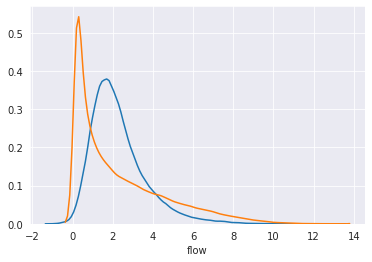

In [0]:
sns.distplot(pred,hist=False)
sns.distplot(y_test,hist=False)

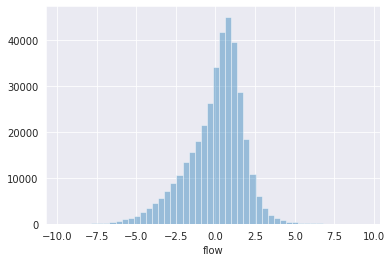

In [0]:
sns.distplot((pred - y_test),kde=False)

In [0]:
scipy.stats.pearsonr(pred,y_test)

(0.6085235338595003, 0.0)

In [0]:
scipy.stats.f_oneway(pred,y_test)

F_onewayResult(statistic=0.22807033298316595, pvalue=0.6329584923603307)

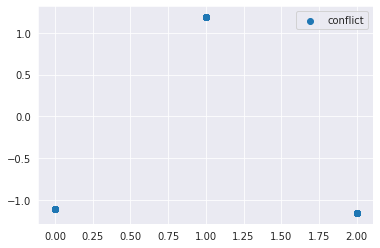

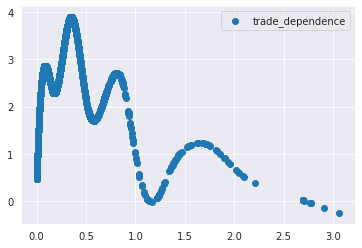

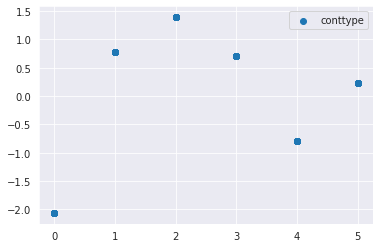

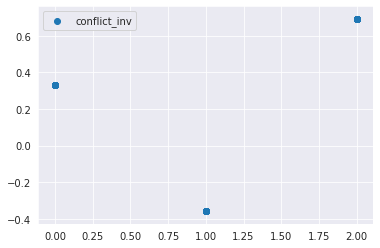

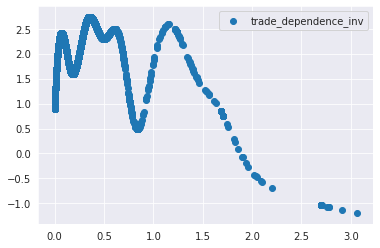

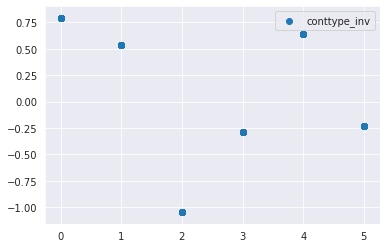

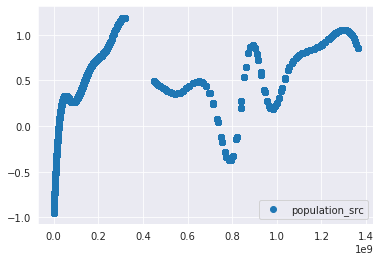

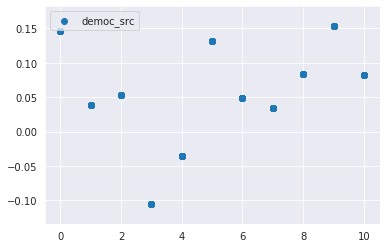

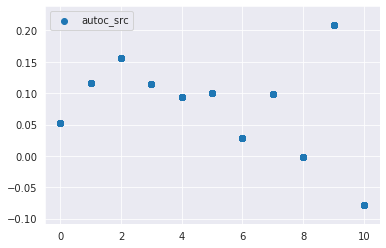

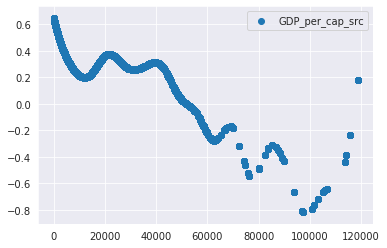

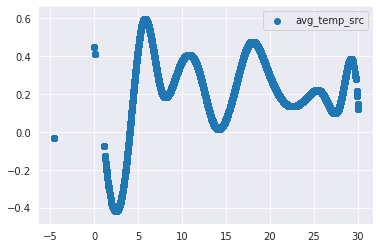

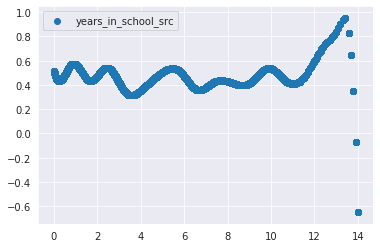

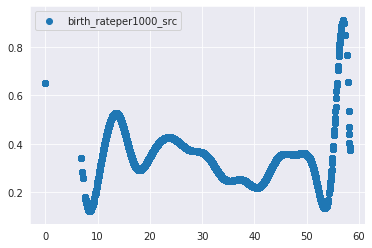

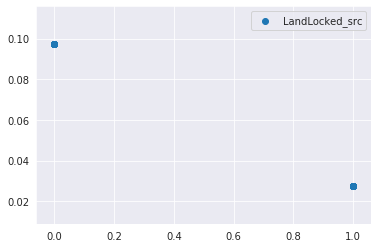

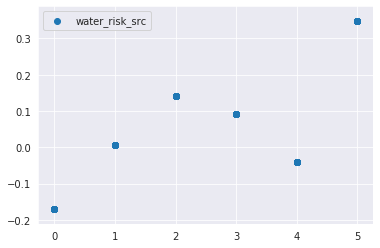

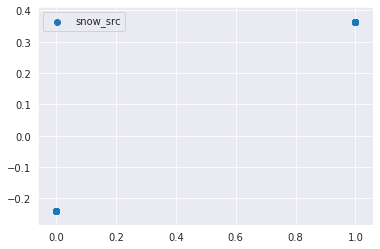

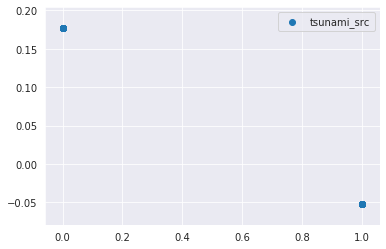

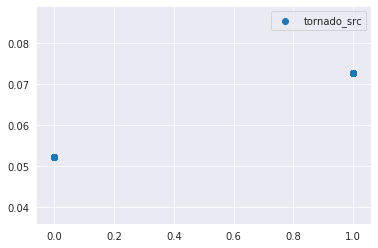

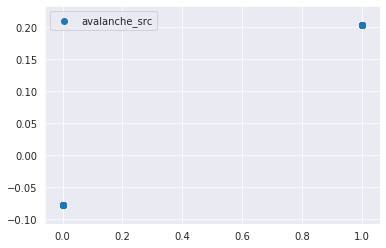

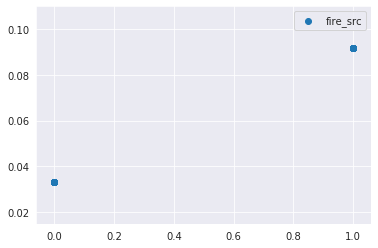

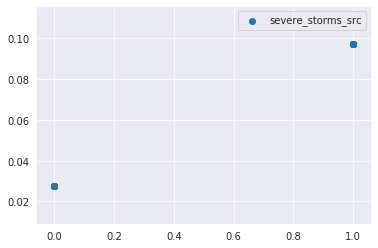

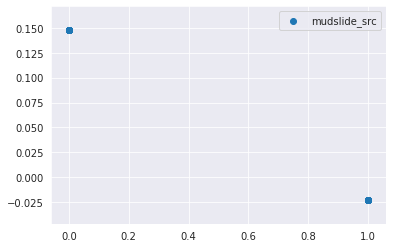

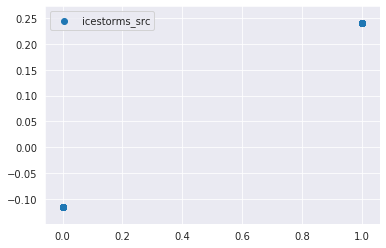

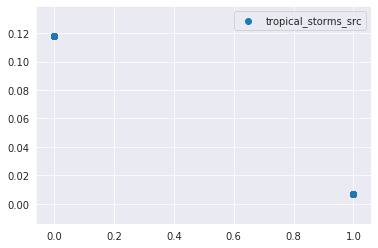

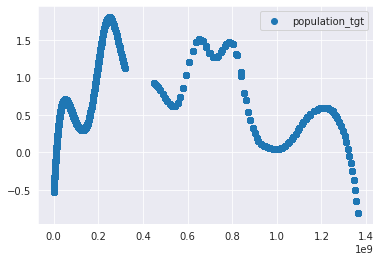

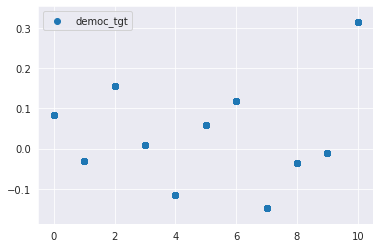

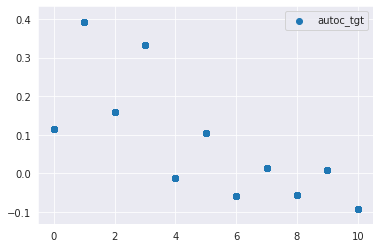

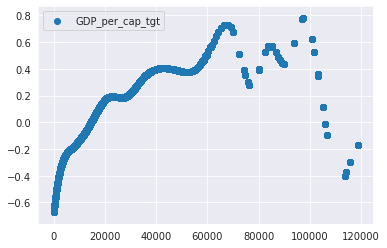

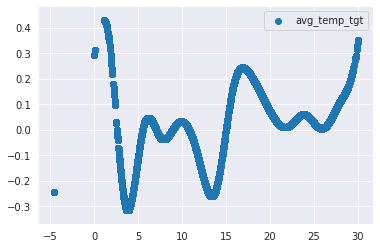

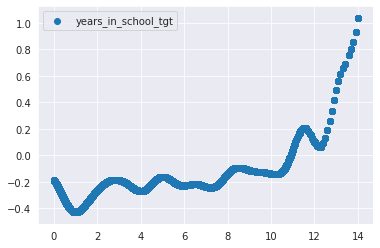

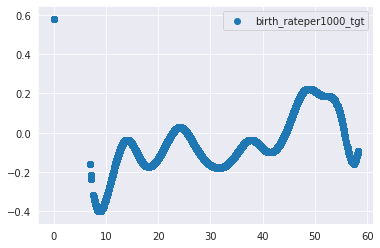

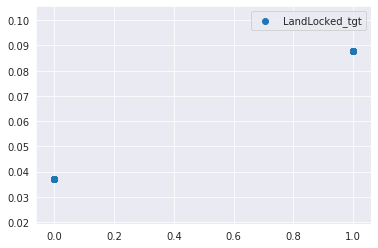

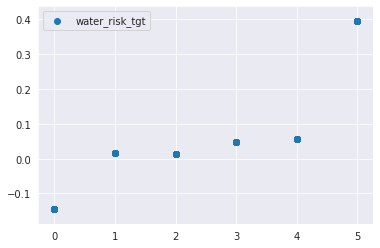

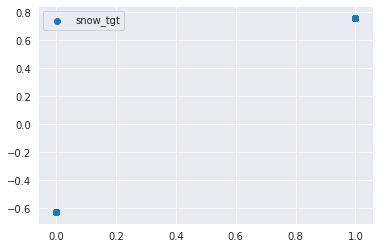

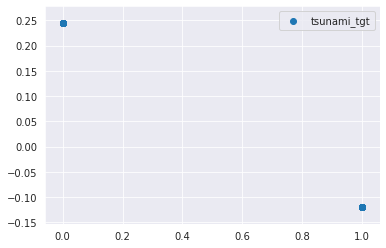

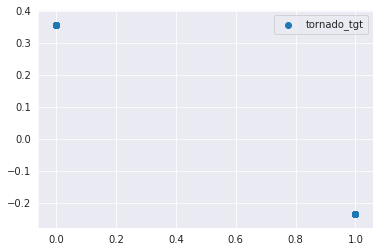

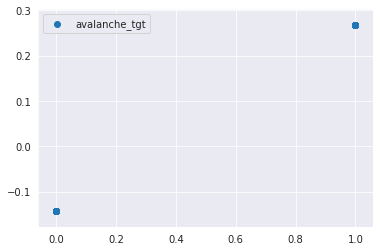

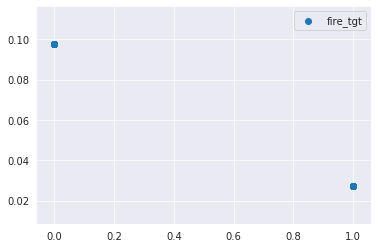

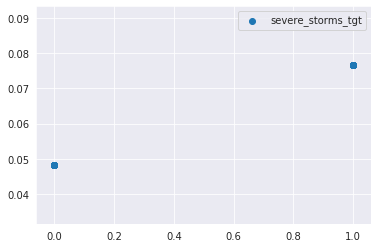

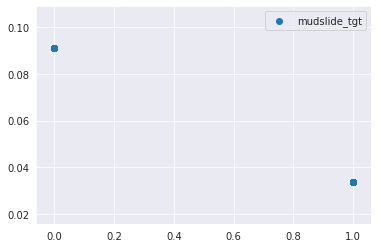

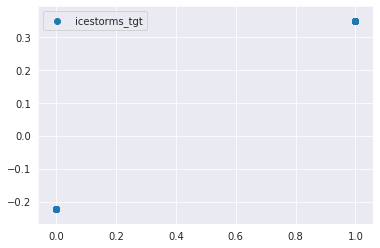

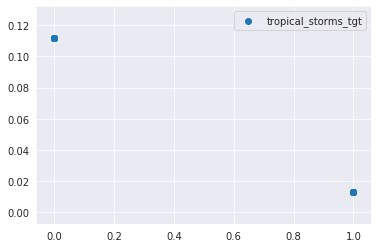

In [0]:
plt.figure()
for i, term in enumerate(gam.terms):
    if i < 0:
      continue
    if term.isintercept:
        continue
    plt.scatter(X[:,i],gam.partial_dependence(term=i,X=X),label=total_regression_df.columns[6:][i])
    plt.legend()
    plt.show()


In [0]:
codes[codes.iso_abb == 'CAN']

,iso_abb,iso_numeric,iso_country
29,CAN,124,Canada


In [0]:
total_regression_df[total_regression_df.src_num == 124][total_regression_df.tgt_num == 840][total_regression_df.year == 2011]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,year,src_abb,tgt_abb,src_num,tgt_num,flow,conflict,trade_dependence,conttype,conflict_inv,trade_dependence_inv,conttype_inv,population_src,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,population_tgt,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
321127,2011,CAN,USA,124,840,10497.0,0.0,0.333306,1.0,0.0,0.051211,1.0,34339328.0,10.0,0.0,52101.79609,4.245508,12.7,11.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,311580009.0,10.0,0.0,49883.11398,10.519771,13.3,12.7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(-1.1849481311494172, 'conflict')
(3.9755223170905873, 'trade_dependence')
(0.5608065189765301, 'conttype')
(0.20433512162244788, 'conflict_inv')
(2.5422749396407696, 'trade_dependence_inv')
(0.7471529235423021, 'conttype_inv')
(0.2520206463835875, 'population_src')
(0.09866119493744475, 'democ_src')
(0.05565900058920391, 'autoc_src')
(0.0472921674218544, 'GDP_per_cap_src')
(0.06795573552407386, 'avg_temp_src')
(0.760479326327987, 'years_in_school_src')
(0.2761075850204171, 'birth_rateper1000_src')
(0.09566644325151008, 'LandLocked_src')
(0.009168638358811243, 'water_risk_src')
(0.35803704295359784, 'snow_src')
(0.1856652350503522, 'tsunami_src')
(0.044100733231156854, 'tornado_src')
(-0.08975891860519965, 'avalanche_src')
(0.03806397756802556, 'fire_src')
(0.0990547001470127, 'severe_storms_src')
(0.14538969888879766, 'mudslide_src')
(-0.08928012668222106, 'icestorms_src')
(0.11852322415856471, 'tropical_storms_src')
(1.2347829791252465, 'population_tgt')
(0.33101821923082264, 'democ_

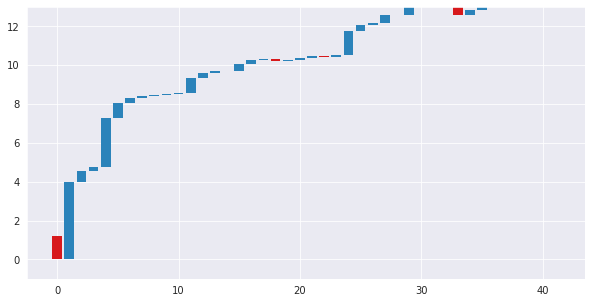

In [0]:
for j in [321127]:
  plt.figure(figsize=(10,5))
  locs = [i for i in range(len(gam.terms)-1)]
  factors=np.array([gam.partial_dependence(term=i,X=X[j].reshape(1,-1)) for i in range(len(gam.terms)-1)]).ravel()
  [print(t) for t in zip(factors, total_regression_df.columns[6:])]
  cum_factors = [gam.coef_[-1]]
  for factor in factors:
    cum_factors.append(factor+cum_factors[-1])
  cum_factors = cum_factors[:-1]
  c = ['#d7191c' if f<0 else '#2b83ba' for f in factors]
  plt.bar(locs,factors,bottom=cum_factors,color=c,linewidth=0)
  # plt.bar([locs[-1]+1],[2*1.88],bottom=[pred[j]-1.88])
  # plt.axhline(y=y[j],c='r',label='Flow')
  # plt.axhline(y=pred[j],label="Prediction")
  # plt.axhline(y=gam.coef_[-1],c='w')
  plt.ylim(-1,13)
  # plt.legend()
  plt.show()

In [0]:
factors=np.array([gam.partial_dependence(term=i,X=X.reshape(-1,42)) for i in range(len(gam.terms)-1)]).T
factors.shape

(2088702, 42)

In [0]:
factor_df = pd.DataFrame(data=factors,columns=total_regression_df.columns[6:])

In [0]:
factor_df

,conflict,trade_dependence,conttype,conflict_inv,trade_dependence_inv,conttype_inv,population_src,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,population_tgt,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.730910,0.015846,-0.039654,0.110522,0.049799,0.109819,-0.030845,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380700,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.011686,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997
1,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.730880,0.015846,-0.039654,0.110522,0.049799,0.109819,-0.023907,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380671,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.037373,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997
2,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.730860,0.015846,-0.039654,0.110522,0.049799,0.109819,0.006073,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380652,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.073581,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997
3,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.730848,0.015846,-0.039654,0.110522,0.049799,0.109819,0.049093,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380641,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.110086,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997
4,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.730840,0.015846,-0.039654,0.110522,0.049799,0.109819,0.077452,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380634,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.126609,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088697,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.458111,-0.198612,0.065926,0.177394,0.159018,0.112595,-0.028530,-0.056980,0.070881,-0.320157,0.051184,-0.102864,-0.245744,0.022387,0.064253,0.113686,-0.22547,0.035076,-0.120198,-0.152693,0.043664,-0.367002,-0.057241,-0.301065,0.001195,-0.025129,0.056382,-0.304663,0.073125,0.086388,-0.179347,0.052388,0.012855,0.117619,-0.280626,0.053997
2088698,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.454516,-0.198612,0.065926,0.174953,0.160478,0.112595,-0.028248,-0.056980,0.070881,-0.320157,0.051184,-0.102864,-0.245744,0.022387,0.064253,0.113686,-0.22547,0.035076,-0.116694,-0.152693,0.043664,-0.347516,-0.067534,-0.301065,0.002073,-0.025129,0.056382,-0.304663,0.073125,0.086388,-0.179347,0.052388,0.012855,0.117619,-0.280626,0.053997
2088699,1.861284,-0.241289,-0.727527,0.504674,1.227544,-0.727528,-0.450500,-0.198612,0.065926,0.171442,0.161550,0.139991,-0.029271,-0.056980,0.070881,-0.320157,0.051184,-0.102864,-0.245744,0.022387,0.064253,0.113686,-0.22547,0.035076,-0.112778,-0.152693,0.043664,-0.320516,-0.074917,-0.236691,-0.001343,-0.025129,0.056382,-0.304663,0.073125,0.086388,-0.179347,0.052388,0.012855,0.117619,-0.280626,0.053997
2088700,

In [0]:
total_regression_df = total_regression_df.reset_index()
total_regression_df

,index,year,src_abb,tgt_abb,src_num,tgt_num,flow,conflict,trade_dependence,conttype,conflict_inv,trade_dependence_inv,conttype_inv,population_src,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,population_tgt,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,tsunami_tgt,tornado_tgt,avalanche_tgt,fire_tgt,severe_storms_tgt,mudslide_tgt,icestorms_tgt,tropical_storms_tgt
0,0,1960,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1961,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55438.0,0.0,0.0,6472.502029,0.000000,0.0,34.529,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,55438.0,0.0,0.0,6472.502029,0.000000,0.0,34.529,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,1962,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56225.0,0.0,0.0,6472.502029,0.000000,0.0,33.320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56225.0,0.0,0.0,6472.502029,0.000000,0.0,33.320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,1963,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56695.0,0.0,0.0,6472.502029,0.000000,0.0,32.050,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56695.0,0.0,0.0,6472.502029,0.000000,0.0,32.050,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,1964,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57032.0,0.0,0.0,6472.502029,0.000000,0.0,30.737,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,57032.0,0.0,0.0,6472.502029,0.000000,0.0,30.737,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088697,2088697,2010,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12697723.0,3.0,2.0,948.331854,20.564583,7.3,36.464,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12697723.0,3.0,2.0,948.331854,20.564583,7.3,36.464,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2088698,2088698,2011,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12894316.0,3.0,2.0,1093.654002,20.305833,7.3,36.526,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12894316.0,3.0,2.0,1093.654002,20.305833,7.3,36.526,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2088699,2088699,2012,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13115131.0,3.0,2.0,1304.969802,19.982500,7.9,36.292,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13115131.0,3.0,2.0,1304.969802,19.982500,7.9,36.292,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2088700,2088700,2013,ZWE,ZWE,716,716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13350356.0,5.0,1.0,1430.000818,19.682292,8.0,35.768,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13350356.0,5.0,1.0,1430.000818,19.682292,8.0,35.768,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
master_df = total_regression_df.join(factor_df,rsuffix="_factor")
master_df = master_df.drop(columns=['index'])
master_df['bias_factor'] = gam.coef_[-1]
master_df['log_prediction'] = pred
master_df['flow_prediction'] = np.exp(pred)
master_df['log_prediction_accuracy_sigma'] = np.std(pred - y)
master_df

,year,src_abb,tgt_abb,src_num,tgt_num,flow,conflict,trade_dependence,conttype,conflict_inv,trade_dependence_inv,conttype_inv,population_src,democ_src,autoc_src,GDP_per_cap_src,avg_temp_src,years_in_school_src,birth_rateper1000_src,LandLocked_src,water_risk_src,snow_src,tsunami_src,tornado_src,avalanche_src,fire_src,severe_storms_src,mudslide_src,icestorms_src,tropical_storms_src,population_tgt,democ_tgt,autoc_tgt,GDP_per_cap_tgt,avg_temp_tgt,years_in_school_tgt,birth_rateper1000_tgt,LandLocked_tgt,water_risk_tgt,snow_tgt,...,population_src_factor,democ_src_factor,autoc_src_factor,GDP_per_cap_src_factor,avg_temp_src_factor,years_in_school_src_factor,birth_rateper1000_src_factor,LandLocked_src_factor,water_risk_src_factor,snow_src_factor,tsunami_src_factor,tornado_src_factor,avalanche_src_factor,fire_src_factor,severe_storms_src_factor,mudslide_src_factor,icestorms_src_factor,tropical_storms_src_factor,population_tgt_factor,democ_tgt_factor,autoc_tgt_factor,GDP_per_cap_tgt_factor,avg_temp_tgt_factor,years_in_school_tgt_factor,birth_rateper1000_tgt_factor,LandLocked_tgt_factor,water_risk_tgt_factor,snow_tgt_factor,tsunami_tgt_factor,tornado_tgt_factor,avalanche_tgt_factor,fire_tgt_factor,severe_storms_tgt_factor,mudslide_tgt_factor,icestorms_tgt_factor,tropical_storms_tgt_factor,bias_factor,log_prediction,flow_prediction,log_prediction_accuracy_sigma
0,1960,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,54211.0,0.0,0.0,6472.502029,0.000000,0.0,35.679,0.0,0.0,0.0,...,-0.730910,0.015846,-0.039654,0.110522,0.049799,0.109819,-0.030845,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380700,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.011686,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997,0.438012,-0.081123,0.922080,1.424926
1,1961,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55438.0,0.0,0.0,6472.502029,0.000000,0.0,34.529,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,55438.0,0.0,0.0,6472.502029,0.000000,0.0,34.529,0.0,0.0,0.0,...,-0.730880,0.015846,-0.039654,0.110522,0.049799,0.109819,-0.023907,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380671,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.037373,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997,0.438012,-0.099812,0.905007,1.424926
2,1962,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56225.0,0.0,0.0,6472.502029,0.000000,0.0,33.320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56225.0,0.0,0.0,6472.502029,0.000000,0.0,33.320,0.0,0.0,0.0,...,-0.730860,0.015846,-0.039654,0.110522,0.049799,0.109819,0.006073,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380652,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.073581,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997,0.438012,-0.106003,0.899422,1.424926
3,1963,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56695.0,0.0,0.0,6472.502029,0.000000,0.0,32.050,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56695.0,0.0,0.0,6472.502029,0.000000,0.0,32.050,0.0,0.0,0.0,...,-0.730848,0.015846,-0.039654,0.110522,0.049799,0.109819,0.049093,0.100781,-0.096148,-0.320157,0.051184,-0.102864,-0.245744,0.021415,-0.020451,0.113686,-0.22547,0.035076,-0.380641,-0.028128,0.106721,-0.014534,-0.020378,-0.387090,-0.110086,0.068931,-0.134165,-0.304663,0.073125,0.086388,-0.179347,-0.008587,0.030947,0.117619,-0.280626,0.053997,0.438012,-0.099464,0.905322,1.424926
4,1964,ABW,ABW,533,533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57032.0,0.0,0.0,6472.502029,0.000000,0.0,30.737,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,57032.0,0.0,0.0,6472.502029,0.000000,0.0,30.737,0.0,0.0,0.0,...,-0.730840,0.015846,-0.039654,0.110522,0.049799,0.109819,0.077452,0.100781,-0.

In [0]:
master_df.to_csv('master_table.csv',index=False,float_format='%.2f')

In [0]:
len(np.unique(master_df.src_abb))

194

In [0]:
print(*('"{}"'.format(item) for item in range(1960,2015)), sep=' , ')

"1960" , "1961" , "1962" , "1963" , "1964" , "1965" , "1966" , "1967" , "1968" , "1969" , "1970" , "1971" , "1972" , "1973" , "1974" , "1975" , "1976" , "1977" , "1978" , "1979" , "1980" , "1981" , "1982" , "1983" , "1984" , "1985" , "1986" , "1987" , "1988" , "1989" , "1990" , "1991" , "1992" , "1993" , "1994" , "1995" , "1996" , "1997" , "1998" , "1999" , "2000" , "2001" , "2002" , "2003" , "2004" , "2005" , "2006" , "2007" , "2008" , "2009" , "2010" , "2011" , "2012" , "2013" , "2014"


In [0]:
#@title Interactive Exploration of Migration
source = "United States of America" #@param ["Aruba" , "Afghanistan" , "Angola" , "Albania" , "United Arab Emirates" , "Argentina" , "Armenia" , "Antigua and Barbuda" , "Australia" , "Austria" , "Azerbaijan" , "Burundi" , "Belgium" , "Benin" , "Burkina Faso" , "Bangladesh" , "Bulgaria" , "Bahrain" , "Bahamas" , "Bosnia and Herzegovina" , "Belarus" , "Belize" , "Bolivia (Plurinational State of)" , "Brazil" , "Barbados" , "Brunei Darussalam" , "Bhutan" , "Botswana" , "Central African Republic" , "Canada" , "Switzerland" , "Chile" , "China" , "Côte d'Ivoire" , "Cameroon" , "Congo, Democratic Republic of the" , "Congo" , "Colombia" , "Comoros" , "Cabo Verde" , "Costa Rica" , "Cuba" , "Cyprus" , "Czechia" , "Germany" , "Djibouti" , "Denmark" , "Dominican Republic" , "Algeria" , "Ecuador" , "Egypt" , "Eritrea" , "Spain" , "Estonia" , "Ethiopia" , "Finland" , "Fiji" , "France" , "Micronesia (Federated States of)" , "Gabon" , "United Kingdom of Great Britain and Northern Ireland" , "Georgia" , "Ghana" , "Guinea" , "Guadeloupe" , "Gambia" , "Guinea-Bissau" , "Equatorial Guinea" , "Greece" , "Grenada" , "Guatemala" , "French Guiana" , "Guam" , "Guyana" , "Hong Kong" , "Honduras" , "Croatia" , "Haiti" , "Hungary" , "Indonesia" , "India" , "Ireland" , "Iran (Islamic Republic of)" , "Iraq" , "Iceland" , "Israel" , "Italy" , "Jamaica" , "Jordan" , "Japan" , "Kazakhstan" , "Kenya" , "Kyrgyzstan" , "Cambodia" , "Kiribati" , "Korea, Republic of" , "Kuwait" , "Lao People's Democratic Republic" , "Lebanon" , "Liberia" , "Libya" , "Saint Lucia" , "Sri Lanka" , "Lesotho" , "Lithuania" , "Luxembourg" , "Latvia" , "Macao" , "Morocco" , "Moldova, Republic of" , "Madagascar" , "Maldives" , "Mexico" , "North Macedonia" , "Mali" , "Malta" , "Myanmar" , "Mongolia" , "Mozambique" , "Mauritania" , "Martinique" , "Mauritius" , "Malawi" , "Malaysia" , "Mayotte" , "Namibia" , "New Caledonia" , "Niger" , "Nigeria" , "Nicaragua" , "Netherlands" , "Norway" , "Nepal" , "New Zealand" , "Oman" , "Pakistan" , "Panama" , "Peru" , "Philippines" , "Papua New Guinea" , "Poland" , "Puerto Rico" , "Korea (Democratic People's Republic of)" , "Portugal" , "Paraguay" , "Palestine, State of" , "French Polynesia" , "Qatar" , "Réunion" , "Romania" , "Russian Federation" , "Rwanda" , "Saudi Arabia" , "nan" , "Senegal" , "Singapore" , "Solomon Islands" , "Sierra Leone" , "El Salvador" , "Somalia" , "Sao Tome and Principe" , "Suriname" , "Slovakia" , "Slovenia" , "Sweden" , "Eswatini" , "Seychelles" , "Syrian Arab Republic" , "Chad" , "Togo" , "Thailand" , "Tajikistan" , "Turkmenistan" , "Timor-Leste" , "Tonga" , "Trinidad and Tobago" , "Tunisia" , "Turkey" , "Tanzania, United Republic of" , "Uganda" , "Ukraine" , "Uruguay" , "United States of America" , "Uzbekistan" , "Saint Vincent and the Grenadines" , "Venezuela (Bolivarian Republic of)" , "Virgin Islands (U.S.)" , "Viet Nam" , "Vanuatu" , "Samoa" , "Yemen" , "South Africa" , "Zambia" , "Zimbabwe"]
target = "Mexico" #@param ["Aruba" , "Afghanistan" , "Angola" , "Albania" , "United Arab Emirates" , "Argentina" , "Armenia" , "Antigua and Barbuda" , "Australia" , "Austria" , "Azerbaijan" , "Burundi" , "Belgium" , "Benin" , "Burkina Faso" , "Bangladesh" , "Bulgaria" , "Bahrain" , "Bahamas" , "Bosnia and Herzegovina" , "Belarus" , "Belize" , "Bolivia (Plurinational State of)" , "Brazil" , "Barbados" , "Brunei Darussalam" , "Bhutan" , "Botswana" , "Central African Republic" , "Canada" , "Switzerland" , "Chile" , "China" , "Côte d'Ivoire" , "Cameroon" , "Congo, Democratic Republic of the" , "Congo" , "Colombia" , "Comoros" , "Cabo Verde" , "Costa Rica" , "Cuba" , "Cyprus" , "Czechia" , "Germany" , "Djibouti" , "Denmark" , "Dominican Republic" , "Algeria" , "Ecuador" , "Egypt" , "Eritrea" , "Spain" , "Estonia" , "Ethiopia" , "Finland" , "Fiji" , "France" , "Micronesia (Federated States of)" , "Gabon" , "United Kingdom of Great Britain and Northern Ireland" , "Georgia" , "Ghana" , "Guinea" , "Guadeloupe" , "Gambia" , "Guinea-Bissau" , "Equatorial Guinea" , "Greece" , "Grenada" , "Guatemala" , "French Guiana" , "Guam" , "Guyana" , "Hong Kong" , "Honduras" , "Croatia" , "Haiti" , "Hungary" , "Indonesia" , "India" , "Ireland" , "Iran (Islamic Republic of)" , "Iraq" , "Iceland" , "Israel" , "Italy" , "Jamaica" , "Jordan" , "Japan" , "Kazakhstan" , "Kenya" , "Kyrgyzstan" , "Cambodia" , "Kiribati" , "Korea, Republic of" , "Kuwait" , "Lao People's Democratic Republic" , "Lebanon" , "Liberia" , "Libya" , "Saint Lucia" , "Sri Lanka" , "Lesotho" , "Lithuania" , "Luxembourg" , "Latvia" , "Macao" , "Morocco" , "Moldova, Republic of" , "Madagascar" , "Maldives" , "Mexico" , "North Macedonia" , "Mali" , "Malta" , "Myanmar" , "Mongolia" , "Mozambique" , "Mauritania" , "Martinique" , "Mauritius" , "Malawi" , "Malaysia" , "Mayotte" , "Namibia" , "New Caledonia" , "Niger" , "Nigeria" , "Nicaragua" , "Netherlands" , "Norway" , "Nepal" , "New Zealand" , "Oman" , "Pakistan" , "Panama" , "Peru" , "Philippines" , "Papua New Guinea" , "Poland" , "Puerto Rico" , "Korea (Democratic People's Republic of)" , "Portugal" , "Paraguay" , "Palestine, State of" , "French Polynesia" , "Qatar" , "Réunion" , "Romania" , "Russian Federation" , "Rwanda" , "Saudi Arabia" , "nan" , "Senegal" , "Singapore" , "Solomon Islands" , "Sierra Leone" , "El Salvador" , "Somalia" , "Sao Tome and Principe" , "Suriname" , "Slovakia" , "Slovenia" , "Sweden" , "Eswatini" , "Seychelles" , "Syrian Arab Republic" , "Chad" , "Togo" , "Thailand" , "Tajikistan" , "Turkmenistan" , "Timor-Leste" , "Tonga" , "Trinidad and Tobago" , "Tunisia" , "Turkey" , "Tanzania, United Republic of" , "Uganda" , "Ukraine" , "Uruguay" , "United States of America" , "Uzbekistan" , "Saint Vincent and the Grenadines" , "Venezuela (Bolivarian Republic of)" , "Virgin Islands (U.S.)" , "Viet Nam" , "Vanuatu" , "Samoa" , "Yemen" , "South Africa" , "Zambia" , "Zimbabwe"]
year = "1960" #@param ["1960" , "1961" , "1962" , "1963" , "1964" , "1965" , "1966" , "1967" , "1968" , "1969" , "1970" , "1971" , "1972" , "1973" , "1974" , "1975" , "1976" , "1977" , "1978" , "1979" , "1980" , "1981" , "1982" , "1983" , "1984" , "1985" , "1986" , "1987" , "1988" , "1989" , "1990" , "1991" , "1992" , "1993" , "1994" , "1995" , "1996" , "1997" , "1998" , "1999" , "2000" , "2001" , "2002" , "2003" , "2004" , "2005" , "2006" , "2007" , "2008" , "2009" , "2010" , "2011" , "2012" , "2013" , "2014"]

src = int(codes.iso_numeric[codes.iso_country == source])
tgt = int(codes.iso_numeric[codes.iso_country == source])
year = int(year)

locs = [i for i in range(len(gam.terms)-1)]
factors=master_df[master_df.src_num == src][master_df.tgt_num == tgt][master_df.year == year]
if not factors.empty:
  factors = factors[0,-42:]
  cum_factors = [gam.coef_[-1]]
  for factor in factors:
    cum_factors.append(factor+cum_factors[-1])
  cum_factors = cum_factors[:-1]
  plt.bar(locs,factors,bottom=cum_factors)
  plt.bar([locs[-1]+1],[2*1.88],bottom=[pred[train_index][j]-1.88])
  plt.axhline(y=list(y[train_index])[j],c='r',label='Flow')
  plt.axhline(y=pred[train_index][j],label="Prediction")
  plt.axhline(y=gam.coef_[-1],c='w')
  plt.ylim(0,5)
  plt.legend()
  plt.show()
else:
  print("Data not available")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


TypeError: ignored

In [0]:
master_df[master_df.src_num == 4 ][master_df.tgt_num == 533][master_df.year == 1960].values[0,-42:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


array([1.2337746646005445, -0.7275275868269122, -0.5293416272286108,
       0.01584574114975329, 0.008412417698527248, 0.19267874496332363,
       -0.18866258156342292, 0.2513179930828537, -0.014940125373186897,
       -0.056979789549067086, -0.05465115719410096, -0.3201569554277794,
       0.051183916287014485, -0.10286397097112253, -0.24574352312123737,
       0.022386924228426062, -0.02045138374675321, 0.11368607267665974,
       -0.2254699831323015, 0.03507556339782865, -0.3806996787782405,
       -0.0281276318376662, 0.10672077305617175, -0.014534308480486174,
       -0.020378319936833617, -0.3870904273101774, -0.011686256110134564,
       0.0689307683160273, -0.13416545582952086, -0.30466322143911206,
       0.07312492403442648, 0.08638831256323042, -0.17934732396850228,
       -0.008586711352389129, 0.030946907429122494, 0.11761884875120603,
       -0.2806256585972352, 0.05399724911593528, 0.43801166788928214,
       0.060550063600010084, 1.0624207848481555, 1.4249258401464437],